Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar100"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar100/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar100/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 39%|███▉      | 39/100 [00:00<00:00, 119.66it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:17<00:00,  2.26it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [10]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 10
num_users = [1,3,5,10]

test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.3
cutoff_round = 5


# save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'

for num_user in num_users:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    # Test performance of aggregator on data 
    aggregator.load_state(dir_path=save_path_FAT)
    aggregator.update_clients()
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()

    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_og, model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
    #  Assign proportion and attack params
    if True:
        for c in aggregator.clients:
            c.unlearning_flag = True
            
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%1 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_og, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_
    gc.collect()
    torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..


  0%|          | 0/100 [00:00<?, ?it/s]


===> Initializing clients..


  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pick

round 0 Test acc:  0.41374999955296515 ( 0.06748327841049037 ) adv acc:  0.10645833485759795 ( 0.036299653979713846 )
round 1 Test acc:  0.3341666668653488 ( 0.06475916981403156 ) adv acc:  0.07541666841134428 ( 0.03554877318309901 )
round 2 Test acc:  0.19541666777804495 ( 0.059627022141860046 ) adv acc:  0.03583333441056311 ( 0.018181187210463943 )
round 3 Test acc:  0.16395833427086473 ( 0.06822113382824817 ) adv acc:  0.024375000759027897 ( 0.01975435127027905 )
round 4 Test acc:  0.1483333345502615 ( 0.07017339519515708 ) adv acc:  0.02708333432674408 ( 0.023917538398313072 )
round 5 Test acc:  0.1266666676849127 ( 0.06788470492013768 ) adv acc:  0.02208333418238908 ( 0.021534049987389177 )
round 6 Test acc:  0.14645833484828472 ( 0.07112409739863758 ) adv acc:  0.02708333416376263 ( 0.024349167809423623 )
round 7 Test acc:  0.15583333438262342 ( 0.07171509937545735 ) adv acc:  0.030000000772997738 ( 0.027876214871479583 )
round 8 Test acc:  0.1583333340473473 ( 0.0746519677223878

  2%|▏         | 2/100 [00:00<00:00, 302.55it/s]


===> Initializing clients..


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


round 0 Test acc:  0.41374999955296515 ( 0.06748327841049037 ) adv acc:  0.10666666841134428 ( 0.03690264896912777 )
round 1 Test acc:  0.37958333306014536 ( 0.07112562269050784 ) adv acc:  0.08708333503454924 ( 0.03554877292220615 )
round 2 Test acc:  0.29166666604578495 ( 0.06777720763340697 ) adv acc:  0.05291666784323752 ( 0.030649791579976805 )
round 3 Test acc:  0.25874999836087226 ( 0.08169110930018618 ) adv acc:  0.03937500109896064 ( 0.02548062355093794 )
round 4 Test acc:  0.24833333268761634 ( 0.08023835971563659 ) adv acc:  0.03666666774079204 ( 0.031224990815194927 )
round 5 Test acc:  0.24687499925494194 ( 0.0809811233933494 ) adv acc:  0.035625000833533704 ( 0.029638300098423314 )
round 6 Test acc:  0.2575000016018748 ( 0.07903058484124574 ) adv acc:  0.037708334252238275 ( 0.030275787009226618 )
round 7 Test acc:  0.2658333331346512 ( 0.07968688726345452 ) adv acc:  0.0381250009406358 ( 0.028191280287756786 )
round 8 Test acc:  0.2672916665673256 ( 0.07704137328595421 )

  4%|▍         | 4/100 [00:00<00:00, 176.29it/s]


===> Initializing clients..


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


round 0 Test acc:  0.41374999955296515 ( 0.06748327841049037 ) adv acc:  0.10666666864417493 ( 0.03699662169351098 )
round 1 Test acc:  0.3858333326876163 ( 0.07282017302149955 ) adv acc:  0.08875000164844096 ( 0.03372426986017311 )
round 2 Test acc:  0.3327083334326744 ( 0.07419445915500689 ) adv acc:  0.06687500192783773 ( 0.0269701164832872 )
round 3 Test acc:  0.31979166604578496 ( 0.07256911332115246 ) adv acc:  0.05416666793171317 ( 0.03106892034070763 )
round 4 Test acc:  0.31395833380520344 ( 0.0757460010721574 ) adv acc:  0.044375001033768055 ( 0.027156152464310464 )
round 5 Test acc:  0.31124999895691874 ( 0.0741514493303247 ) adv acc:  0.04000000099185854 ( 0.027335366256876117 )
round 6 Test acc:  0.3204166658222675 ( 0.07703151282500409 ) adv acc:  0.04000000110827386 ( 0.027208046656103484 )
round 7 Test acc:  0.3266666684299707 ( 0.08045444008520525 ) adv acc:  0.042500001308508215 ( 0.02647063406537949 )
round 8 Test acc:  0.3308333341032267 ( 0.0823314772727313 ) adv a

  9%|▉         | 9/100 [00:00<00:00, 212.61it/s]


===> Initializing clients..


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


round 0 Test acc:  0.41374999955296515 ( 0.06748327841049037 ) adv acc:  0.1064583349507302 ( 0.037010110356615895 )
round 1 Test acc:  0.3914583336561918 ( 0.06812181674694207 ) adv acc:  0.08916666838340462 ( 0.030629959867588548 )
round 2 Test acc:  0.34812499955296516 ( 0.06480439212903111 ) adv acc:  0.06583333523012698 ( 0.03128054144079444 )
round 3 Test acc:  0.3431250028312206 ( 0.059566942205265795 ) adv acc:  0.061458334675990045 ( 0.03160561599736673 )
round 4 Test acc:  0.3464583341032267 ( 0.06598314776704182 ) adv acc:  0.06041666835080832 ( 0.03204543302902148 )
round 5 Test acc:  0.34395833387970925 ( 0.07300560155325181 ) adv acc:  0.053958334820345046 ( 0.02674386635372104 )
round 6 Test acc:  0.3518749989569187 ( 0.0676101859946828 ) adv acc:  0.054375001415610316 ( 0.027002282963425012 )
round 7 Test acc:  0.35645833164453505 ( 0.07172205933253031 ) adv acc:  0.055000001564621925 ( 0.027118567235276888 )
round 8 Test acc:  0.3566666696220636 ( 0.06977642732868551 )

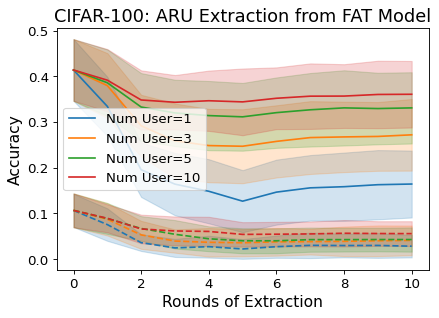

In [11]:

# Initialize a new figure
plt.figure(figsize=(6, 4), dpi=80)

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 11, 1)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('CIFAR-100: ARU Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()